In [1]:
import os
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import osmnx as ox
import h3
from collections import Counter
from datetime import datetime
from shapely.geometry import Point, LineString, Polygon
from dotenv import load_dotenv

# Set plotting style
plt.rcParams['figure.figsize'] = [12, 8]

# Load environment variables
load_dotenv()

True

## 1. Data Integrated

### Readtime GTFS

In [2]:
# API_KEY = os.getenv('GTFS_API_KEY')
# trip_updates_url = f"https://gtfsapi.translink.ca/v3/gtfsrealtime?apikey={API_KEY}"

In [3]:
# feed = gtfs_realtime_pb2.FeedMessage()
# response = requests.get(trip_updates_url)
# feed.ParseFromString(response.content)

# for entity in feed.entity:
#     if entity.trip_update:
#         print(entity.trip_update)

### Load basic transit data

I've loaded GTFS static data files containing information about stops, routes, and schedules

In [4]:
# geojson_url = "https://opendata.vancouver.ca/explore/dataset/local-area-boundary/download/?format=geojson"
# geojson_file = "./data/vancouver_community_boundaries.geojson"

# response = requests.get(geojson_url)
# with open(geojson_file, 'wb') as file:
#     file.write(response.content)

In [5]:
# Load basic transit data
stops = pd.read_csv('./data/google_transit/stops.txt')
routes = pd.read_csv('./data/google_transit/routes.txt')
trips = pd.read_csv('./data/google_transit/trips.txt')
stop_times = pd.read_csv('./data/google_transit/stop_times.txt')
shapes = pd.read_csv('./data/google_transit/shapes.txt')

# Load geographic boundary data
bc_boundaries = gpd.read_file('./data/BCGW/ABMS_LGL_ADMIN_AREAS_SVW.geojson')

# Display basic information about our datasets
print("Dataset Sizes:")
print(f"Stops: {len(stops)} records")
print(f"Routes: {len(routes)} records")
print(f"Trips: {len(trips)} records")
print(f"Stop Times: {len(stop_times)} records")
print(f"Shapes: {len(shapes)} records")

Dataset Sizes:
Stops: 8789 records
Routes: 238 records
Trips: 60997 records
Stop Times: 1779653 records
Shapes: 157647 records


## 2. Data Transform

In [6]:
# Convert stops to GeoDataFrame
def create_stops_gdf(stops):
    """Convert stops DataFrame to GeoDataFrame"""
    stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
    return gpd.GeoDataFrame(stops, geometry='geometry', crs="EPSG:4326")

stops_gdf = create_stops_gdf(stops)

# Create shapes GeoDataFrame
def create_shapes_gdf(shapes):
    """Convert shapes data to GeoDataFrame with LineString geometries"""
    shapes['geometry'] = shapes.apply(lambda row: Point(float(row['shape_pt_lon']), float(row['shape_pt_lat'])), axis=1)
    gdf_shapes = gpd.GeoDataFrame(shapes[['shape_id', 'geometry']])
    gdf_shapes.crs = "EPSG:4326"
    
    # Group shapes and create LineStrings
    gdf_shapes = gpd.GeoDataFrame(gdf_shapes[['shape_id', 'geometry']].groupby(by='shape_id').agg(list))
    gdf_shapes = gdf_shapes[[len(g) > 1 for g in gdf_shapes['geometry'].to_list()]]
    gdf_shapes['geometry'] = gdf_shapes['geometry'].apply(lambda x: LineString(x))
    # gdf_shapes['shape_id'] = gdf_shapes.index
    gdf_shapes = gpd.GeoDataFrame(gdf_shapes, crs="EPSG:4326")  # Explicitly set CRS for gdf_shapes
    return gdf_shapes

gdf_shapes = create_shapes_gdf(shapes)

def parse_time_string(time_string):
    hour_value = int(time_string.split(':')[0])
    if hour_value > 23: hour_value = hour_value-24
    time_string = str(hour_value) + ':' + time_string.split(':', 1)[1]    
    parsed_time = datetime.strptime(time_string, "%H:%M:%S")
    return parsed_time

def create_stop_timess_df(stop_times):
    df_stop_times = stop_times.copy()
    df_stop_times['departure_time'] = df_stop_times['departure_time'].apply(parse_time_string)
    df_stop_times['minutes_since_midnight'] = df_stop_times['departure_time'].dt.hour * 60 + df_stop_times['departure_time'].dt.minute
    df_stop_times['hour_minute'] = df_stop_times['departure_time'].dt.strftime('%H:%M')
    return df_stop_times

df_stop_times = create_stop_timess_df(stop_times)

In [7]:
# Filter Metro Vancouver boundaries
metro_boundaries = bc_boundaries[bc_boundaries['ADMIN_AREA_GROUP_NAME'] == 'Metro Vancouver Regional District']

## 3. Data Visualization

### Analysis 1: Transit Coverage by Community


/Users/bosstation/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


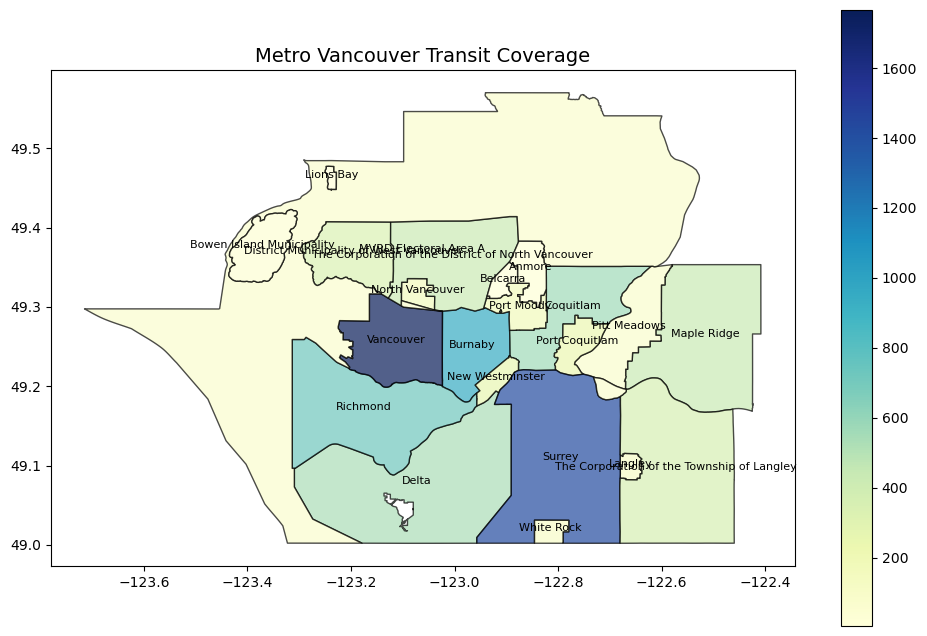

In [8]:
# Spatial join
stops_within_bc = gpd.sjoin(stops_gdf, metro_boundaries, how='left', op='within')

# Count the number of bus stops in each area
admin_area_stop_counts = stops_within_bc.groupby('ADMIN_AREA_NAME').size().reset_index(name='stop_count')

# Merge the stop counts into the administrative areas
metro_boundaries = metro_boundaries.merge(admin_area_stop_counts, on='ADMIN_AREA_NAME', how='left')
metro_boundaries['stop_count'] = metro_boundaries['stop_count'].fillna(0)  # Fill areas with no stops with 0

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
metro_boundaries.plot(
    column='stop_count', 
    ax=ax, 
    legend=True, 
    cmap='YlGnBu', 
    edgecolor='black', 
    alpha=0.7
)

# Annotate area names, removing the "City of" prefix
for idx, row in metro_boundaries.iterrows():
    area_name = row['ADMIN_AREA_NAME'].replace('City of ', '').replace('Village of ', '')
    
    centroid = row.geometry.centroid
    plt.annotate(
        text=area_name,  # Use the name without the prefix
        xy=(centroid.x, centroid.y), 
        fontsize=8, 
        ha='center'
    )

plt.title('Metro Vancouver Transit Coverage', fontsize=14)
plt.show()

<Figure size 1500x600 with 0 Axes>

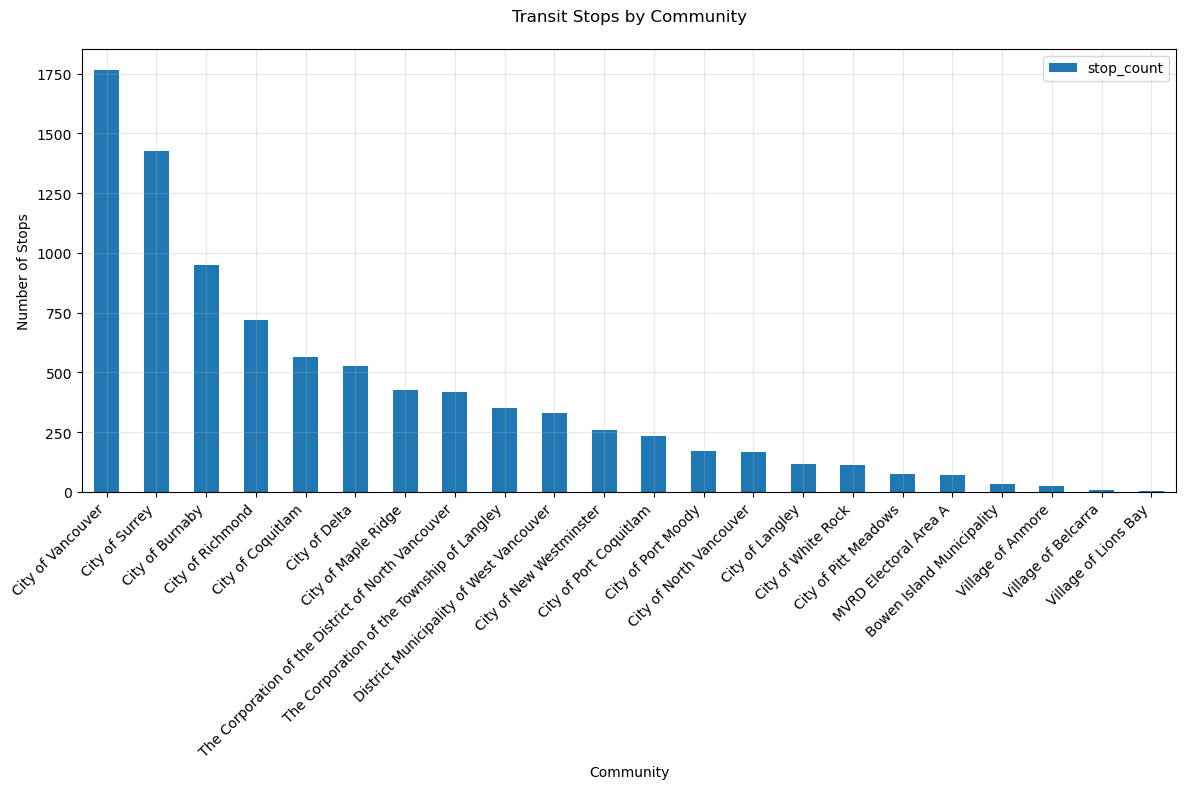

In [51]:
# Visualize results
plt.figure(figsize=(15, 6))
ax = admin_area_stop_counts.sort_values(by='stop_count', ascending=False).plot(kind='bar', x='ADMIN_AREA_NAME', y='stop_count')
plt.title('Transit Stops by Community', pad=20)
plt.xlabel('Community')
plt.ylabel('Number of Stops')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

<Axes: >

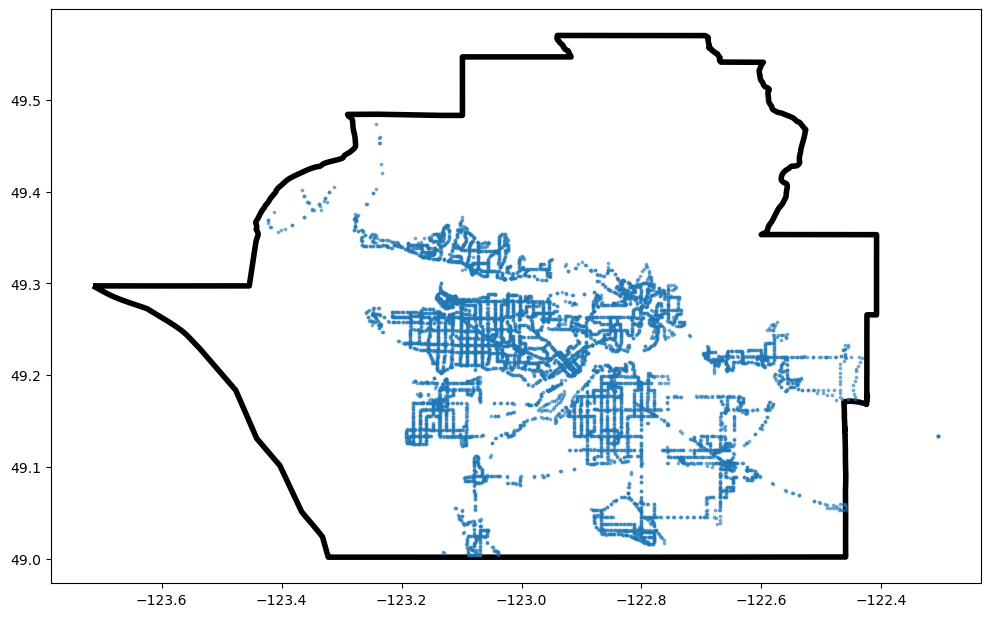

In [9]:
city = 'Metro Vancouver Regional District'
admin = ox.geocode_to_gdf(city)

f, ax = plt.subplots(1,1,figsize=(12,10))

admin.plot(ax=ax, color = 'none', edgecolor = 'k', linewidth = 4)
stops_within_bc.plot(ax=ax, markersize = 3, alpha = 0.5)

### Analysis 2: Transport Types Distribution


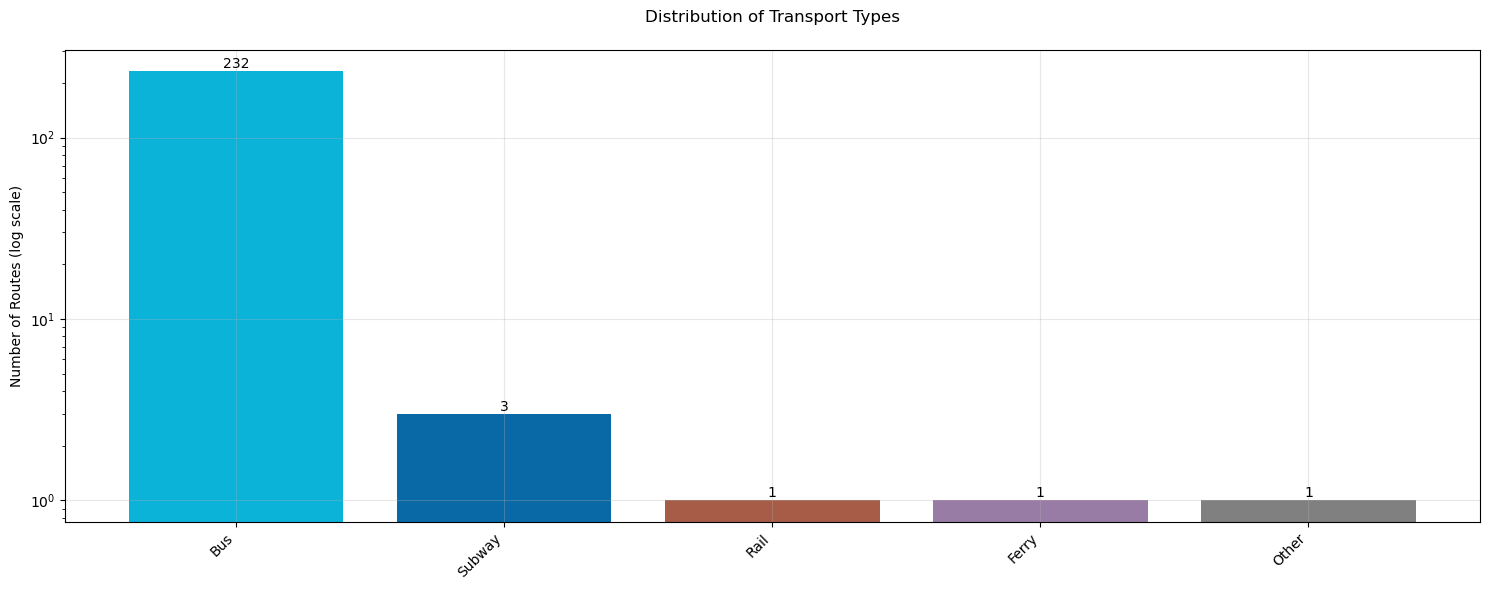

In [11]:
# Define transport type mapping and colors
transport_type_mapping = {
    0: 'Tram', 1: 'Subway', 2: 'Rail', 3: 'Bus', 4: 'Ferry',
    5: 'Cable Tram', 6: 'Aerial Lift', 7: 'Funicular',
    11: 'Trolleybus', 12: 'Monorail'
}
transport_colors = {
    'Subway': '#0869A6',  # Assign a color for SkyTrain
    'Bus': '#0BB3D9',
    'Rail': '#A65C47',
    'Ferry': '#997CA6',
    'Tram': '#F2B705',
    'Other': '#808080'
}

# Process route types
routes['route_type'] = routes['route_type'].astype(int)
routes['route_type_en'] = routes['route_type'].map(transport_type_mapping).fillna('Other')
transport_counts = dict(Counter(routes.route_type_en))

# Visualize transport type distribution
plt.figure(figsize=(15, 6))
labels = list(transport_counts.keys())
values = list(transport_counts.values())
colors = [transport_colors.get(l, '#808080') for l in labels]

bars = plt.bar(range(len(labels)), values, color=colors)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.title('Distribution of Transport Types', pad=20)
plt.ylabel('Number of Routes (log scale)')
plt.yscale('log')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()

### Analysis 3: Service Frequency Analysis

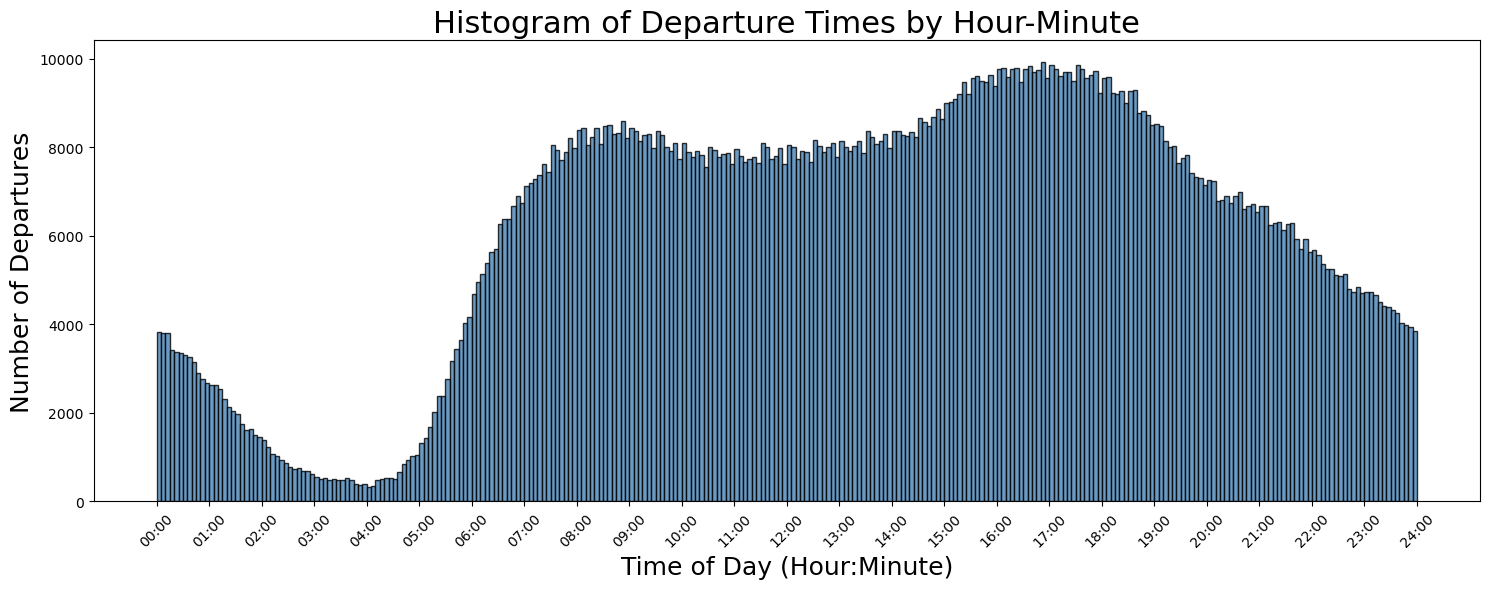

In [12]:
# Generate time intervals
bins = np.arange(0, 1441, 5)  # 5-minute intervals, totaling 1440 minutes (24 hours)

# Plot continuous histogram
plt.figure(figsize=(15, 6))
plt.hist(df_stop_times['minutes_since_midnight'], bins=bins, color='steelblue', alpha=0.8, edgecolor='black')

# Set x-axis and y-axis labels
plt.xlabel('Time of Day (Hour:Minute)', fontsize=18)
plt.ylabel('Number of Departures', fontsize=18)
plt.title('Histogram of Departure Times by Hour-Minute', fontsize=22)

# Set x-axis ticks to display in time format
tick_positions = np.arange(0, 1441, 60)  # One tick per hour
tick_labels = [f'{int(tick//60):02d}:{int(tick%60):02d}' for tick in tick_positions]  # Convert to HH:MM format

plt.xticks(tick_positions, tick_labels, rotation=45, fontsize=10)

plt.tight_layout()
plt.show()

### Analysis 4: Spatial Distribution of Services

Analyze the spatial distribution of transit services using hexagonal grid

/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_62475/311298745.py:25: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  gdf_stops = gpd.sjoin(gdf_stop_times, hexagons_gdf)


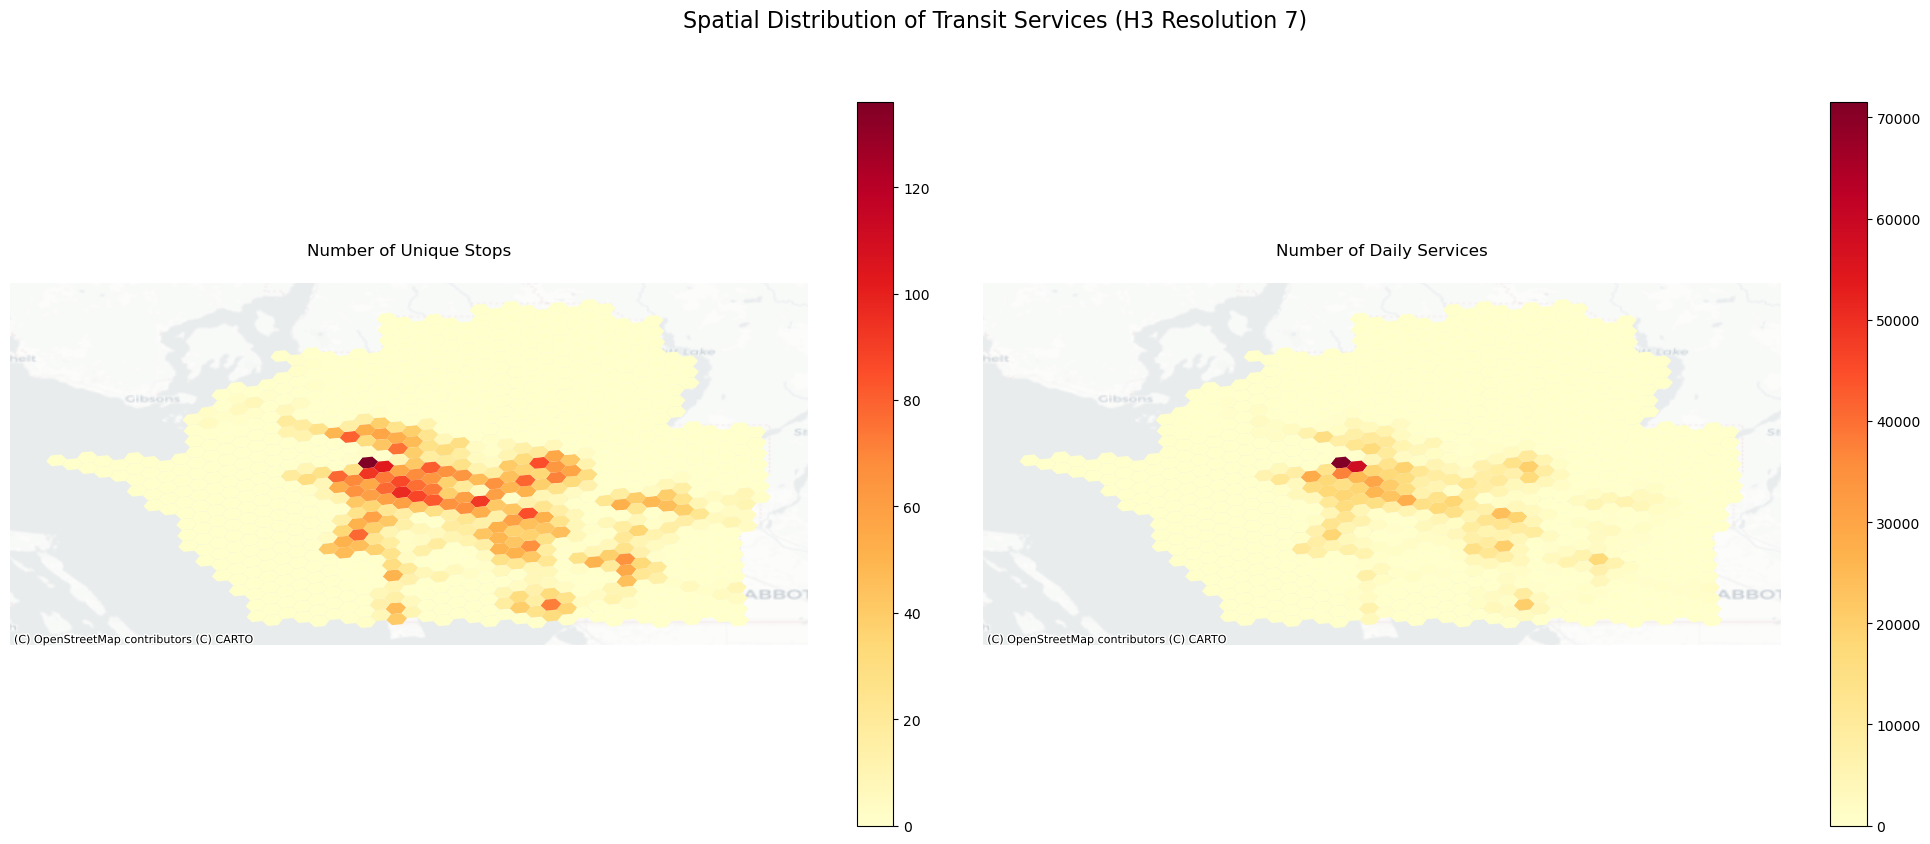

In [13]:
# Create hexagonal grid
resolution = 7

def create_hexagon_grid(admin_gdf, resolution):
    """Create hexagonal grid from administrative boundary"""
    coords = list(admin_gdf.geometry.to_list()[0].exterior.coords)
    admin_geojson = {"type": "Polygon", "coordinates": [coords]}
    hexagons = h3.polyfill(admin_geojson, resolution, geo_json_conformant=True)
    hexagon_geometries = {
        hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True)) 
        for hex_id in hexagons
    }
    return gpd.GeoDataFrame(hexagon_geometries.items(), columns=['hex_id', 'geometry'])

hexagons_gdf = create_hexagon_grid(admin, resolution)

# Analyze stop distribution
def parse_time_string(time_string):
    hour, minute, second = map(int, time_string.split(':'))
    hour %= 24
    return datetime.strptime(f"{hour}:{minute}:{second}", "%H:%M:%S")

stop_times['departure_time'] = stop_times['departure_time'].apply(parse_time_string)
gdf_stop_times = stops_gdf.merge(stop_times, on='stop_id')
gdf_stops = gpd.sjoin(gdf_stop_times, hexagons_gdf)
stop_counts = gdf_stops.groupby('hex_id')['stop_id'].agg(['nunique', 'count']).fillna(0)
hexagons_analysis = hexagons_gdf.join(stop_counts, on='hex_id').fillna(0)

# Visualize spatial distribution
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.suptitle(f'Spatial Distribution of Transit Services (H3 Resolution {resolution})', fontsize=16, y=1.05)

hexagons_analysis.plot(column='nunique', cmap='YlOrRd', legend=True, ax=axes[0])
hexagons_analysis.plot(column='count', cmap='YlOrRd', legend=True, ax=axes[1])

axes[0].set_title('Number of Unique Stops', pad=20)
axes[1].set_title('Number of Daily Services', pad=20)

for ax in axes:
    ax.axis('off')
    ctx.add_basemap(ax, alpha=0.5, crs="EPSG:4326", 
                   source=ctx.providers.CartoDB.Positron)

plt.tight_layout()

### Analysis 5: Transit Network Visualization


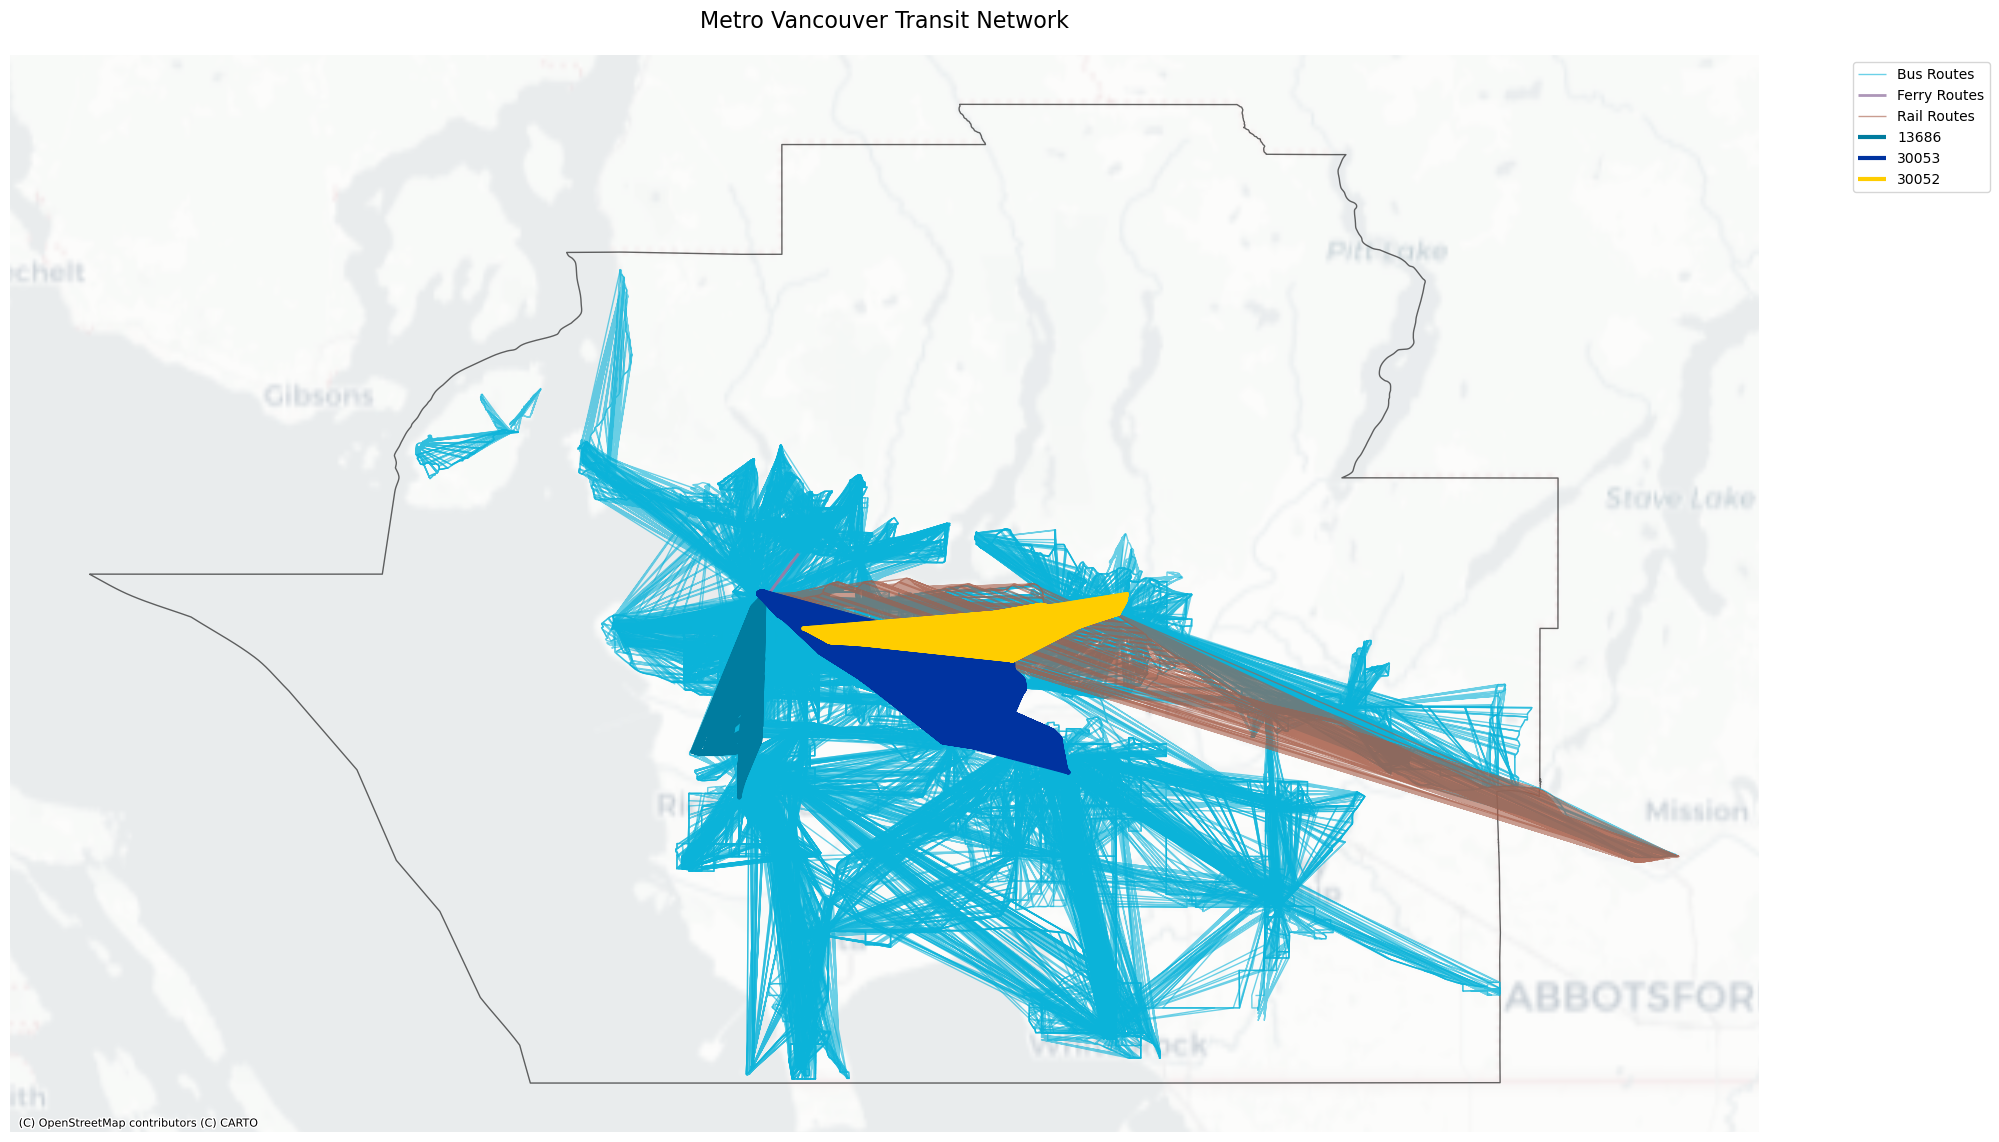

In [38]:
# Prepare route data
df_trips = trips[['route_id', 'shape_id']].drop_duplicates()
df_trips = df_trips.merge(routes[['route_id', 'route_type', 'route_type_en', 'route_short_name']], 
                         on='route_id')
gdf_shapes_new = gdf_shapes.merge(df_trips, on='shape_id')

# Define distinct colors for SkyTrain lines
skytrain_colors = {
    '13686': '#007c9f',      # Canada Line - Light Blue
    '30053': '#0033a0',      # Expo Line - Dark Blue
    '30052': '#ffcd00'       # Millennium Line - Yellow
}

# Create network visualization
plt.figure(figsize=(20, 20))
ax = plt.gca()

# Plot administrative boundary
admin.plot(ax=ax, edgecolor='k', color='none', alpha=0.6)

# Plot bus routes first
bus_subset = gdf_shapes_new[gdf_shapes_new.route_type_en == 'Bus']
if not bus_subset.empty:
    bus_subset.plot(ax=ax, color=transport_colors['Bus'], alpha=0.6, linewidth=1, 
                    label='Bus Routes', zorder=1)

# Plot ferry routes above bus routes
ferry_subset = gdf_shapes_new[gdf_shapes_new.route_type_en == 'Ferry']
if not ferry_subset.empty:
    ferry_subset.plot(ax=ax, color=transport_colors['Ferry'], alpha=0.8, linewidth=2, 
                      label='Ferry Routes', zorder=2)

# Plot other transport types (excluding Bus and Ferry)
for transport, color in transport_colors.items():
    if transport in ['Bus', 'Ferry', 'Subway']:  # Skip already plotted or SkyTrain
        continue
    subset = gdf_shapes_new[gdf_shapes_new.route_type_en == transport]
    if not subset.empty:
        subset.plot(ax=ax, color=color, alpha=0.6, linewidth=1, 
                   label=f'{transport} Routes', zorder=1)

# Plot SkyTrain lines with unique colors
for line, color in skytrain_colors.items():
    line_subset = gdf_shapes_new[gdf_shapes_new['route_id'] == line]
    if not line_subset.empty:
        line_subset.plot(ax=ax, color=color, linewidth=3, alpha=1.0, 
                         label=f'{line}', zorder=3)

# Add basemap
ctx.add_basemap(ax, alpha=0.5, crs=admin.crs, 
               source=ctx.providers.CartoDB.Positron)

# Customize plot
plt.title('Metro Vancouver Transit Network', pad=20, fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axis('off')

# Adjust aspect ratio
bounds = admin.total_bounds
y_coord = np.mean([bounds[1], bounds[3]])
ax.set_aspect(1 / np.cos(y_coord * np.pi / 180), adjustable='box')

plt.tight_layout()


## 4. Future Outlook

- Real-Time Data Integration: Incorporating GTFS-Realtime feeds would enable the monitoring of live performance, delays, and service reliability.
- Cloud-Based Dashboards: Transitioning to cloud storage would allow scalable data processing and the creation of interactive dashboards for real-time decision-making.
- Passenger Flow Analysis: Combining this data with passenger flow patterns could optimize scheduling and identify high-demand routes.
- Demographic Insights: Integrating data on population density and housing could provide a deeper understanding of transit equity and accessibility, supporting more inclusive and sustainable development.